In [1]:
import numpy as np
from scipy.integrate import solve_ivp, OdeSolver
import matplotlib.pyplot as plt
from joblib import load

import os, sys
# local modules
directory_to_prepend = os.path.abspath("../../src")
if directory_to_prepend not in sys.path:
    sys.path = [directory_to_prepend] + sys.path

from utils.utils import get_median_from_experiment, get_summary
from utils.swim import backward 
from hamiltonians.lotka_volterra import LotkaVolterra
from error_functions.index import l2_error, l2_error_relative, mean_squared_error, mean_absolute_error
from utils.grid import generate_grid
from utils.plot import plot_2d, plot_ground_truth_trajectory_2d, plot_predicted_trajectories_2d, plot_predicted_trajectory_errors, plot_predicted_trajectory_energy
from integrators.semi_implicit_euler import SemiImplicitEuler

#EXPERIMENT_DIR = '../../old_old_cluster/out/lotka_volterra_domain/random/100q_train100p_train_lotka_volterra.pkl'
#EXPERIMENT_DIR = '../../old_cluster/out/main/lotkavolterra-domain10-random-singlelayer-neuronscaling/random/[130]qtrain[130]ptrain100neurons_lotka_volterra.pkl'



#EXPERIMENT_DIR = '../../lin-placed-random-cluster/out/solve-hamil/lotka-volterra/2-2/[100]qtrain[100]ptrain[1500]neurons_lotka_volterra.pkl'
#EXPERIMENT_DIR = '../../lin-placed-random-cluster/out/solve-hamil/lotka-volterra/5-5/10000domain[100]qtrain[100]ptrain[1500]neurons_lotka_volterra.pkl'
EXPERIMENT_DIR = '../../lin-placed-random-cluster/out/solve-hamil/lotka-volterra/large/0-8/10000domain[100]qtrain[100]ptrain[1500]neurons_lotka_volterra_large.pkl'


# load experiment
experiment = load(EXPERIMENT_DIR)
print(f"-> LOADED EXPERIMENT: {EXPERIMENT_DIR}")
print(f"                      {experiment.keys()} ")
print(f"                      n_runs = {len(experiment['runs'])} ")
print(f"                      single run includes keys: {experiment['runs'][0].keys()}")
print(f"-> SUMMARY:\n{get_summary(experiment, ['ELM', 'U-SWIM', 'A-SWIM', 'SWIM'], ['test'], ['function_errors'], ['l2_error_relative'], ['median', 'mean'])}")
print(f"-> ")
print(f"-> ELM bias min: {np.min(experiment['runs'][0]['ELM'][0].biases)}, max: {np.max(experiment['runs'][0]['ELM'][0].biases)}")

domain_params = experiment['domain_params']
H = experiment['domain_params']['H']
dH = experiment['domain_params']['dH']

print(f"-> DOMAIN PARAMS: {domain_params}")
elm_params = experiment['elm_params']
uswim_params = experiment['uswim_params']
aswim_params = experiment['aswim_params']
swim_params = experiment['swim_params']

print(f"-> ELM PARAMS: {elm_params}")
print(f"-> USWIM PARAMS: {uswim_params}")
print(f"-> ASWIM PARAMS: {aswim_params}")
print(f"-> SWIM PARAMS: {swim_params}")

elm_median_error, _, _, ELM = get_median_from_experiment(EXPERIMENT_DIR, 'ELM', error_function='l2_error_relative') 
uswim_median_error, _, _, USWIM = get_median_from_experiment(EXPERIMENT_DIR, 'U-SWIM', error_function='l2_error_relative') 
aswim_median_error, _, _, ASWIM = get_median_from_experiment(EXPERIMENT_DIR, 'A-SWIM', error_function='l2_error_relative') 
swim_median_error, _, _, SWIM = get_median_from_experiment(EXPERIMENT_DIR, 'SWIM', error_function='l2_error_relative') 

print(f"-> MEDIAN ERRORS")
print(f"- ELM:    {elm_median_error}")
print(f"- U-SWIM: {uswim_median_error}")
print(f"- A-SWIM: {aswim_median_error}")
print(f"- SWIM:   {swim_median_error}")

-> LOADED EXPERIMENT: ../../lin-placed-random-cluster/out/solve-hamil/lotka-volterra/large/0-8/10000domain[100]qtrain[100]ptrain[1500]neurons_lotka_volterra_large.pkl
                      dict_keys(['domain_params', 'elm_params', 'uswim_params', 'aswim_params', 'swim_params', 'runs']) 
                      n_runs = 100 
                      single run includes keys: dict_keys(['train_random_seed', 'test_random_seed', 'model_random_seed', 'train_function_errors', 'train_gradient_errors', 'test_function_errors', 'test_gradient_errors', 'train_times', 'ELM', 'U-SWIM', 'A-SWIM', 'SWIM'])
-> SUMMARY:
test function_errors median (l2_error_relative)
- ELM   	: 3.3096796750396336e-07
- mean time 	: 3.18991858959198
- U-SWIM   	: 1.5503040163391586e-07
- mean time 	: 3.1460982871055605
- A-SWIM   	: 2.894146988004829e-08
- mean time 	: 6.719775636196136
- SWIM   	: 2.894146988004829e-08
- mean time 	: 3.152722029685974
test function_errors mean (l2_error_relative)
- ELM   	: 0.00015711120293

# **Ground Truth**

q_plot_range shape (100,)
p_plot_range shape (100,)
q_plot_grid shape (100, 100)
p_plot_grid shape (100, 100)


<Figure size 640x480 with 0 Axes>

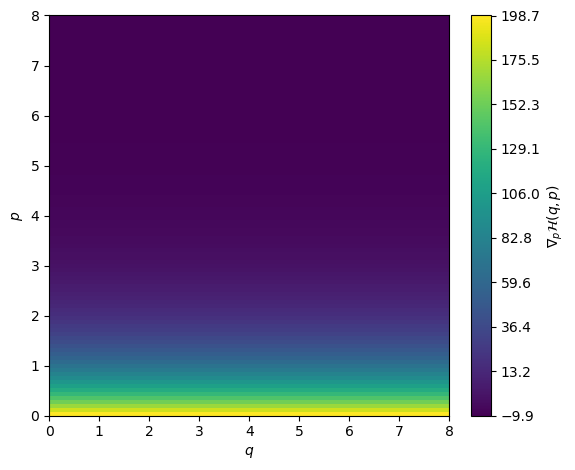


lim for q: [0.0, 8.0]
lim for p: [0.0, 8.0]


<Figure size 640x480 with 0 Axes>

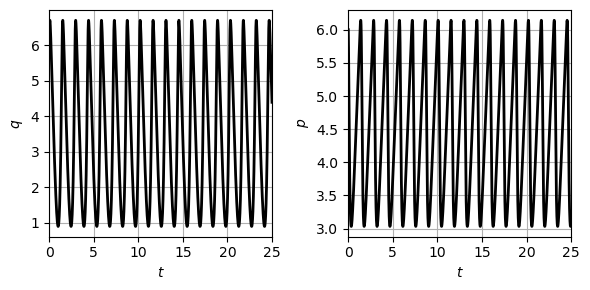

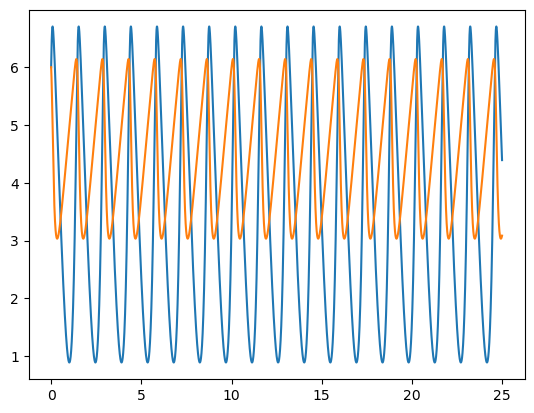

In [3]:
#domain_params['q_test_lim'] = [[-5, 5]]
#domain_params['p_test_lim'] = [[-5, 5]]

# p = ln(x)
# q = ln(y)

# plot the ground truth phase space, linearly spaced in the test set range
[q_plot_range], [p_plot_range], [q_plot_grid], [p_plot_grid] = generate_grid(domain_params["q_test"], domain_params["p_test"], 
                                                                             domain_params["q_test_lim"], domain_params["p_test_lim"], dof=1, linspace=True)
print(f'q_plot_range shape {q_plot_range.shape}')
print(f'p_plot_range shape {p_plot_range.shape}')
print(f'q_plot_grid shape {q_plot_grid.shape}')
print(f'p_plot_grid shape {p_plot_grid.shape}')
x_plot  = np.column_stack([q_plot_grid.flatten(), p_plot_grid.flatten()]) # (N,2)

# alpha=1.1, beta=0.4, gamma=0.1, delta=0.4
#α = 2/3, β = 4/3, γ = 1 = δ.
#lotka_volterra = LotkaVolterra(alpha=1, beta=0.5, gamma=1, delta=0.5)
#lotka_volterra = LotkaVolterra(alpha=0.5, beta=1.5, gamma=1, delta=1)
#lotka_volterra = LotkaVolterra(alpha=0.1, gamma=0.4, beta=0.02, delta=0.02)
#lotka_volterra = LotkaVolterra(alpha=-2/3, beta=-4/3, gamma=-1, delta=-1)
#transform = lambda x: np.log(x)
#lotka_volterra = LotkaVolterra(alpha=3.5, beta=0.025, gamma=10, delta=0.07)
#lotka_volterra = LotkaVolterra()
#H = lotka_volterra.H
#dH = lotka_volterra.dH
#H = LotkaVolterra().H
#print(f"-> lotka volterra created: alpha={lotka_volterra.alpha}, beta={lotka_volterra.beta}, gamma={lotka_volterra.gamma}, delta={lotka_volterra.delta}")

y_plot = H(x_plot).reshape((domain_params["p_test"][0], domain_params["q_test"][0])) 
y_plot = dH(x_plot)[:,1].reshape((domain_params["p_test"][0], domain_params["q_test"][0])) 

# for 2-2 ground truth phase plot
#plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"][0] + domain_params["p_test_lim"][0], contourlines=15, xlabel=r'$q$', ylabel=r'$p$', 
#        aspect=1, verbose=True, save='lotka_volterra_ground_truth_phase.pdf', dpi=100, colorbar_v=5)

plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"][0] + domain_params["p_test_lim"][0], contourlines=0, xlabel=r'$q$', ylabel=r'$p$', 
        aspect=1, verbose=True, save='lotka_volterra_large_ground_truth_phase_gradient_p.pdf', dpi=100, colorbar_v=10)

# for 0-8 ground truth phase plot for the large lotka-volterra
#plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"][0] + domain_params["p_test_lim"][0], contourlines=30, xlabel=r'$q$', ylabel=r'$p$', 
#        aspect=1, verbose=True, save='lotka_volterra_ground_truth_phase.pdf', dpi=100, colorbar_v=10)

def dt_true(t, x): 
    """
    ground truth time derivatives of q and p 
    """
    x = x.reshape(1,-1)
    dH_true = dH(x).T.reshape(-1)
    #print("dH is:", str(dH))
    return [dH_true[1], -dH_true[0]] # [dH/dp, -dH/dq][q^dot, p^dot]

# RK45
t_span = [0, 25]
n_steps = 50000
t_eval = np.linspace(t_span[0], t_span[1], n_steps)

# from yildiz paper we took this initial value
#y0 = [0.4, -1.8]
y0 = [6, 6]
# another initial value that does not beyond 1
#y0 = [0.4, 0] 

motion_true = solve_ivp(dt_true, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-13)
# get integrated trajectories of shape (N,2)
traj_true = motion_true.y.T

q_train_lim_start = domain_params['q_train_lim'][0][0]
q_train_lim_end = domain_params['q_train_lim'][0][1]
p_train_lim_start = domain_params['p_train_lim'][0][0]
p_train_lim_end = domain_params['p_train_lim'][0][1]
print(f"lim for q: [{q_train_lim_start}, {q_train_lim_end}]")
print(f"lim for p: [{p_train_lim_start}, {p_train_lim_end}]")
if np.any(traj_true[:,0] < q_train_lim_start):
    print(f"WARNING: found q={np.min(traj_true[:,0])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,0] > q_train_lim_end):
    print(f"WARNING: found q={np.max(traj_true[:,0])}, which is out of bounds for this experiment")
    
if np.any(traj_true[:,1] < p_train_lim_start):
    print(f"WARNING: found p={np.min(traj_true[:,1])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,1] > p_train_lim_end):
    print(f"WARNING: found p={np.max(traj_true[:,1])}, which is out of bounds for this experiment")

plot_ground_truth_trajectory_2d(t_span, t_eval, traj_true, verbose=True, save='lotka_volterra_ground_truth_integration.pdf', linewidth=2)

plt.clf()
plt.plot(t_eval, traj_true[:,0])
plt.plot(t_eval, traj_true[:,1])

# **Predictions**

<Figure size 640x480 with 0 Axes>

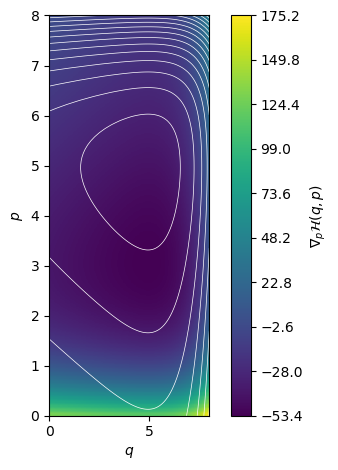

<Figure size 640x480 with 0 Axes>

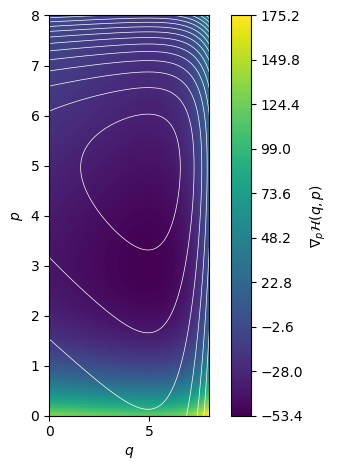

<Figure size 640x480 with 0 Axes>

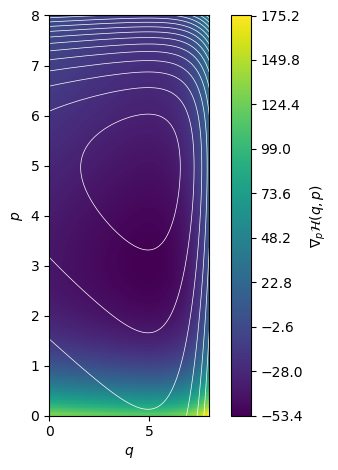

<Figure size 640x480 with 0 Axes>

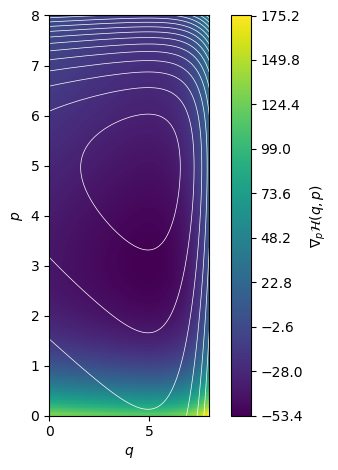


-> integrating ELM
-> integrating USWIM
-> integrating ASWIM
-> integrating SWIM


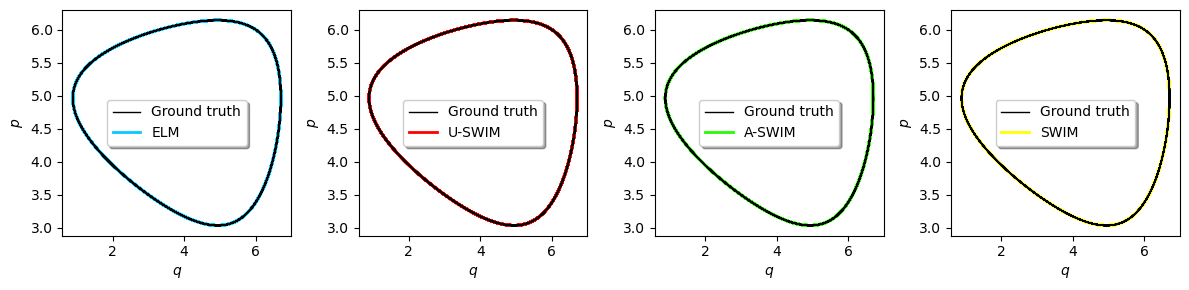

<Figure size 640x480 with 0 Axes>

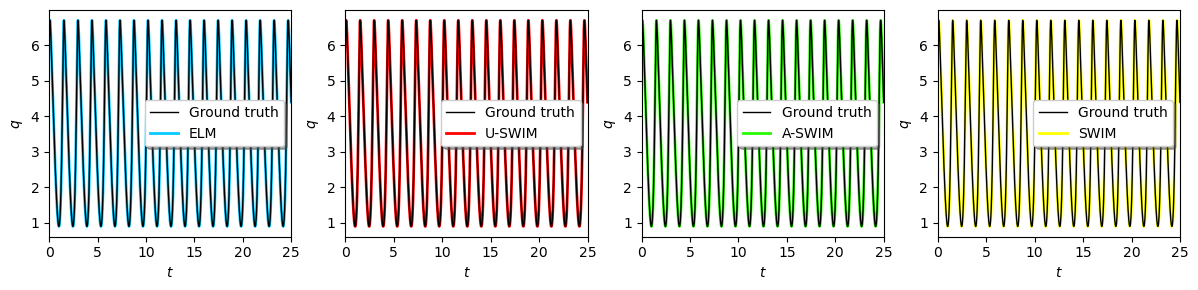

<Figure size 640x480 with 0 Axes>

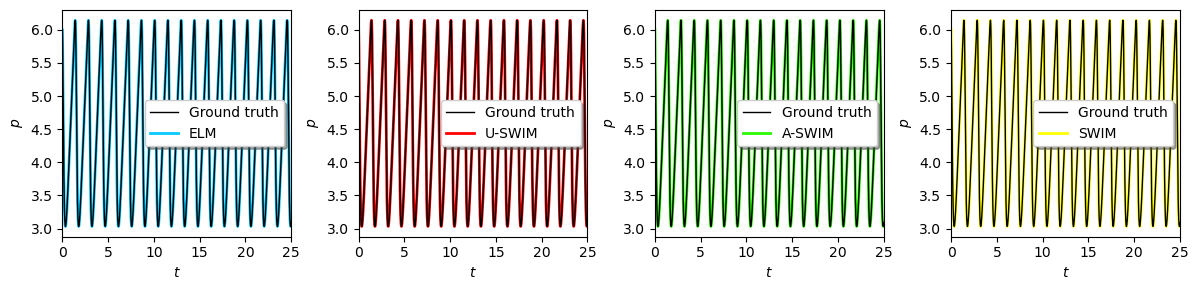

<Figure size 640x480 with 0 Axes>

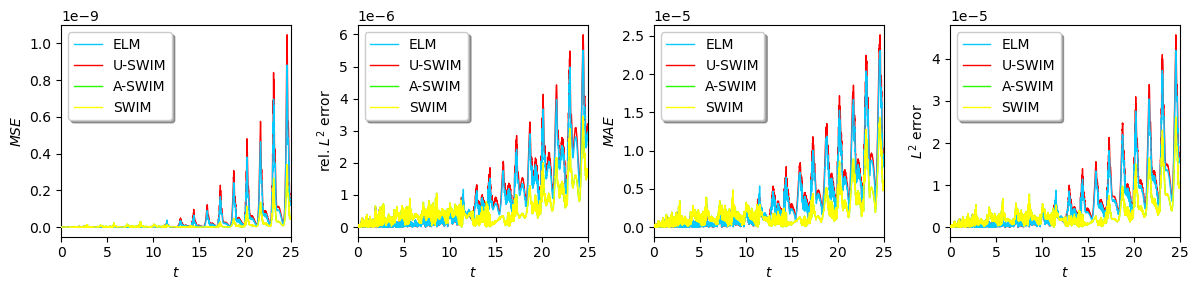

<Figure size 640x480 with 0 Axes>

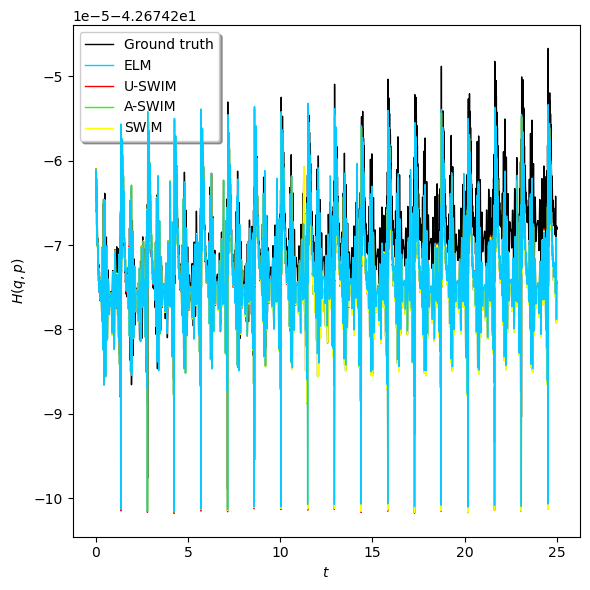

<Figure size 640x480 with 0 Axes>

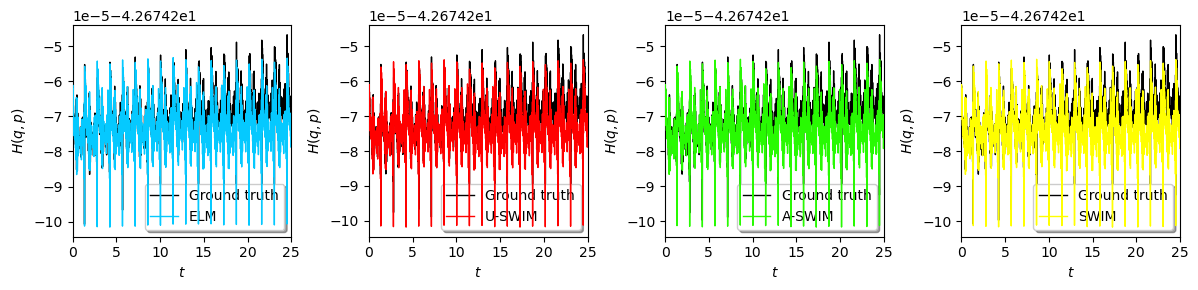

In [4]:
# phase
y_plot = ELM.transform(x_plot).reshape((domain_params["p_test"][0], domain_params["q_test"][0])) 
plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"][0] + domain_params["p_test_lim"][0], contourlines=20, xlabel=r'$q$', ylabel=r'$p$', 
        aspect=2.5, verbose=True, save='lotka_volterra_elm_phase.pdf')
y_plot = USWIM.transform(x_plot).reshape((domain_params["p_test"][0], domain_params["q_test"][0])) 
plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"][0] + domain_params["p_test_lim"][0], contourlines=20, xlabel=r'$q$', ylabel=r'$p$', 
        aspect=2.5, verbose=True, save='lotka_volterra_uswim_phase.pdf')
y_plot = ASWIM.transform(x_plot).reshape((domain_params["p_test"][0], domain_params["q_test"][0])) 
plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"][0] + domain_params["p_test_lim"][0], contourlines=20, xlabel=r'$q$', ylabel=r'$p$', 
        aspect=2.5, verbose=True, save='lotka_volterra_aswim_phase.pdf')
y_plot = SWIM.transform(x_plot).reshape((domain_params["p_test"][0], domain_params["q_test"][0])) 
plot_2d(y_plot, q_plot_range, p_plot_range, extent=domain_params["q_test_lim"][0] + domain_params["p_test_lim"][0], contourlines=20, xlabel=r'$q$', ylabel=r'$p$', 
        aspect=2.5, verbose=True, save='lotka_volterra_swim_phase.pdf')

def dt_pred_elm(t, x):
    """
    ELM
    predicted time derivatives of q and p 
    """
    x = x.reshape(1,-1)
    dH_hat = backward(ELM, elm_params['activation'], x).T.reshape(-1)
    #print("dH_hat is:", str(dH_hat))
    return [dH_hat[1], -dH_hat[0]] 

def dt_pred_uswim(t, x):
    """
    U-SWIM
    predicted time derivatives of q and p
    """
    x = x.reshape(1,-1)
    dH_hat = backward(USWIM, uswim_params['activation'], x).T.reshape(-1)
    #print("dH_hat is:", str(dH_hat))
    return [dH_hat[1], -dH_hat[0]] 

def dt_pred_aswim(t, x):
    """
    A-SWIM
    predicted time derivatives of q and p
    """
    x = x.reshape(1,-1)
    dH_hat = backward(ASWIM, aswim_params['activation'], x).T.reshape(-1)
    #print("dH_hat is:", str(dH_hat))
    return [dH_hat[1], -dH_hat[0]] 

def dt_pred_swim(t,x):
    """
    SWIM
    predicted time derivatives of q and p
    """
    x = x.reshape(1,-1)
    dH_hat = backward(SWIM, aswim_params['activation'], x).T.reshape(-1)
    return [dH_hat[1], -dH_hat[0]]

print(f"-> integrating ELM")
motion_pred_elm = solve_ivp(dt_pred_elm, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)
print(f"-> integrating USWIM")
motion_pred_uswim = solve_ivp(dt_pred_uswim, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)
print(f"-> integrating ASWIM")
motion_pred_aswim = solve_ivp(dt_pred_aswim, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)
print(f"-> integrating SWIM")
motion_pred_swim = solve_ivp(dt_pred_swim, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)

# get integrated trajectories of shape (N,2)
traj_true = motion_true.y.T
traj_pred_elm = motion_pred_elm.y.T
traj_pred_uswim = motion_pred_uswim.y.T
traj_pred_aswim = motion_pred_aswim.y.T
traj_pred_swim = motion_pred_swim.y.T

plot_predicted_trajectories_2d(t_span, t_eval, traj_true, traj_pred_elm, traj_pred_uswim, traj_pred_aswim, traj_pred_swim, 
                               zorders=[2,1,1,1,1], linewidths=[1,2,2,2,2], verbose=True, 
                               save=['lotka_volterra_predicted_integration_q_against_p.pdf', 'lotka_volterra_predicted_integration_t_against_q.pdf', 'lotka_volterra_predicted_integration_t_against_p.pdf'])



plot_predicted_trajectory_errors(t_span, t_eval, traj_true, traj_pred_elm, traj_pred_uswim, traj_pred_aswim, traj_pred_swim, 
                                zorders=[5,4,3,8], linewidths=[1,1,1,1], verbose=True, save='lotka_volterra_predicted_integration_errors.pdf')

# true energies at the predicted trajectories
energy_true = H(traj_true)
energy_elm = H(traj_pred_elm)
energy_uswim = H(traj_pred_uswim)
energy_aswim = H(traj_pred_aswim)
energy_swim = H(traj_pred_swim)

plot_predicted_trajectory_energy(t_span, t_eval, energy_true, energy_elm, energy_uswim, energy_aswim, energy_swim, 
                                 zorders=[2,14,7,8,9], linewidths=[1,1,1,1,1], verbose=True, save='lotka_volterra_integration_energies.pdf')

In [5]:
dH_elm =   lambda x: backward(ELM, elm_params['activation'], x)
dH_uswim = lambda x: backward(USWIM, uswim_params['activation'], x)
dH_aswim = lambda x: backward(ASWIM, aswim_params['activation'], x)
dH_swim = lambda x: backward(SWIM, swim_params['activation'], x)

# **Semi-Implicit Euler**

lim for q: [0.0, 8.0]
lim for p: [0.0, 8.0]


<Figure size 640x480 with 0 Axes>

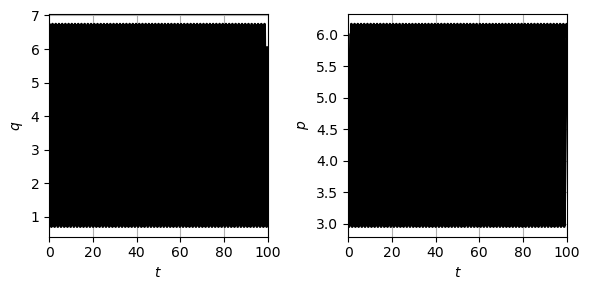

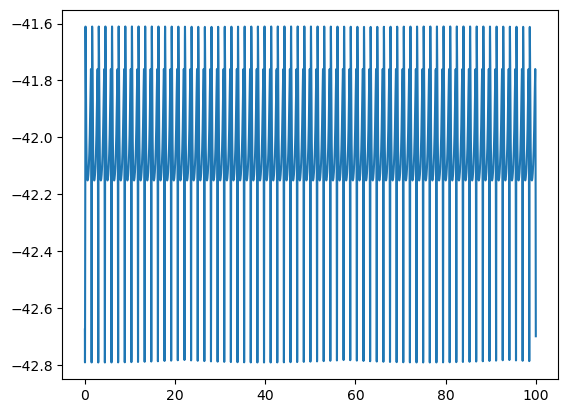

In [6]:
semi_implicit_euler = SemiImplicitEuler()

t_span = [0, 100]
n_steps = 10000
t_eval = np.linspace(t_span[0], t_span[1], n_steps)


# use the same params as used in rk45
dt = (t_span[1] - t_span[0]) / n_steps

# t_eval is already defined before while integratin with rk45
traj_true = np.array([y0])
for i in range(n_steps-1):
    y_next = semi_implicit_euler.step(traj_true[-1].reshape(1,-1), dH, dt)
    traj_true = np.append(traj_true, y_next, axis=0)

print(f"lim for q: [{q_train_lim_start}, {q_train_lim_end}]")
print(f"lim for p: [{p_train_lim_start}, {p_train_lim_end}]")
if np.any(traj_true[:,0] < q_train_lim_start):
    print(f"WARNING: found q={np.min(traj_true[:,0])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,0] > q_train_lim_end):
    print(f"WARNING: found q={np.max(traj_true[:,0])}, which is out of bounds for this experiment")
    
if np.any(traj_true[:,1] < p_train_lim_start):
    print(f"WARNING: found p={np.min(traj_true[:,1])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,1] > p_train_lim_end):
    print(f"WARNING: found p={np.max(traj_true[:,1])}, which is out of bounds for this experiment")

plot_ground_truth_trajectory_2d(t_span, t_eval, traj_true, verbose=True, linewidth=2)

energy_true = H(traj_true)
plt.clf()
plt.plot(t_eval, energy_true)
plt.show()

-> integrating ELM
-> integrating U-SWIM
-> integrating A-SWIM
-> integrating SWIM


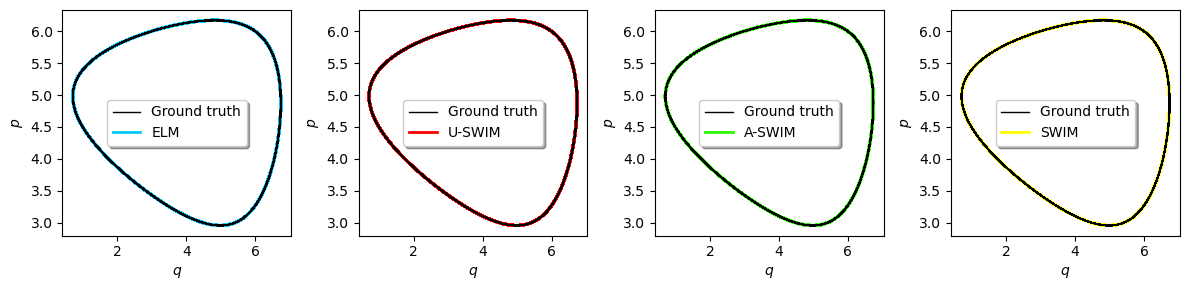

<Figure size 640x480 with 0 Axes>

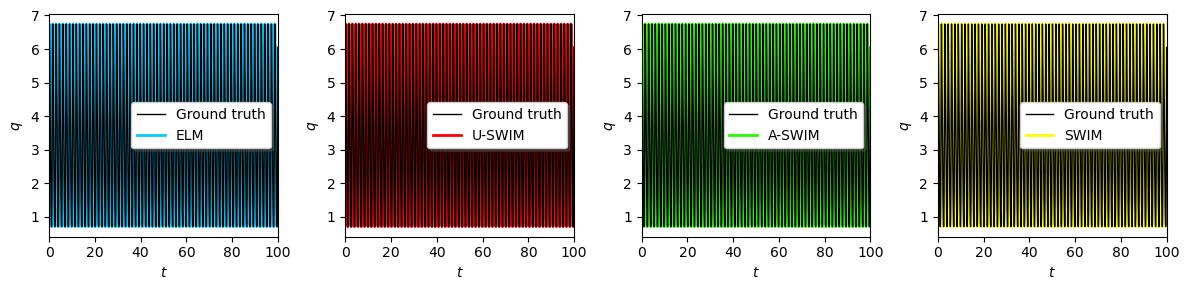

<Figure size 640x480 with 0 Axes>

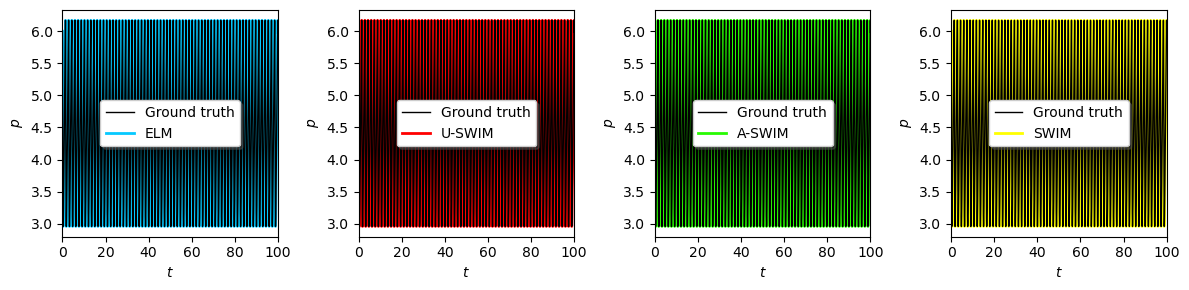

<Figure size 640x480 with 0 Axes>

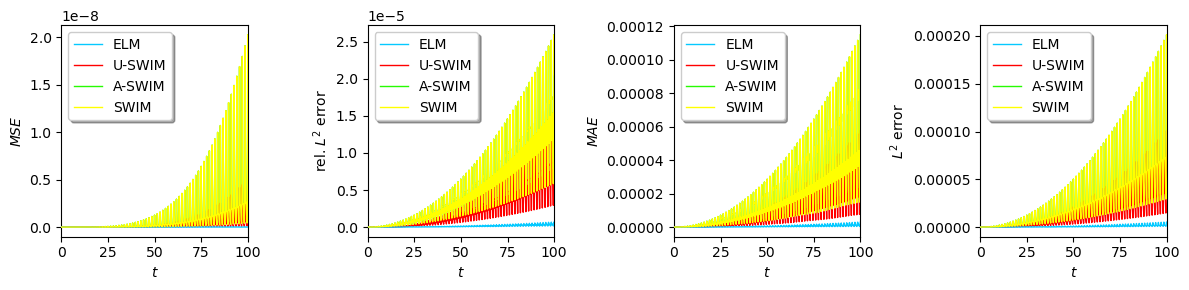

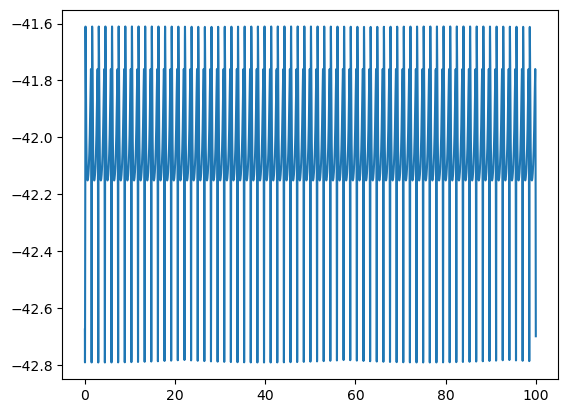

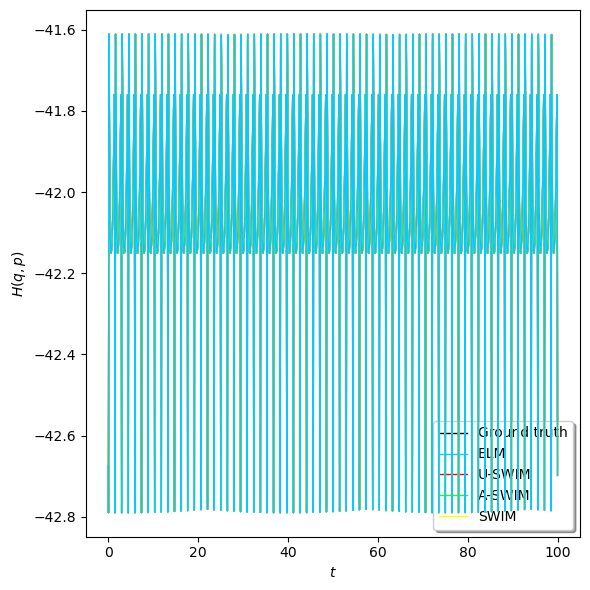

<Figure size 640x480 with 0 Axes>

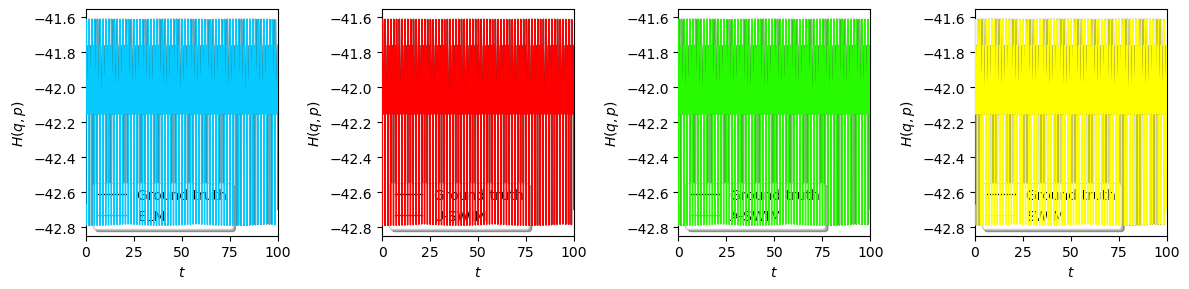

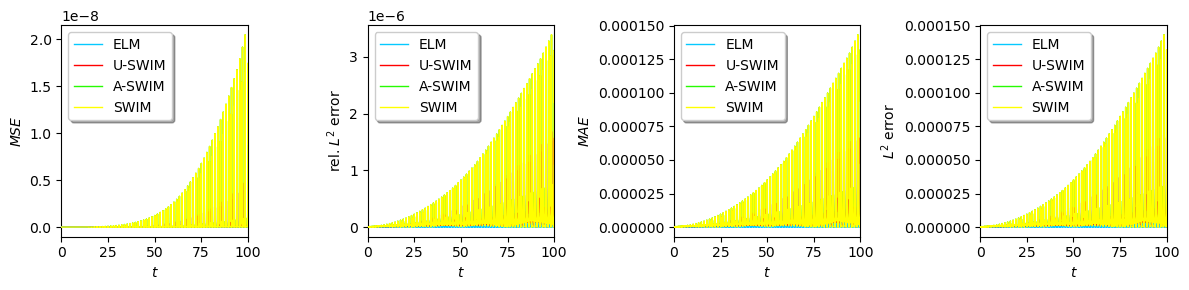

-------- ENERGIES ----
-> energy_true[0]    = [-42.67426462]
-> energy_true[-1]   = [-42.69816723]
-> mean(energy_true) = -42.02954585709492
-> std(energy_true)  = 0.21238133991878314
----------------------
-> energy_elm[0]     = [-42.67426462]
-> energy_elm[-1]    = [-42.69816472]
-> mean(energy_elm) = -42.02954575463035
-> std(energy_elm)  = 0.21238134027803007
----------------------
-> energy_uswim[0]    = [-42.67426462]
-> energy_uswim[-1]   = [-42.6981196]
-> mean(energy_uswim) = -42.029543867697726
-> std(energy_uswim)  = 0.21238132983005945
----------------------
-> energy_aswim[0]    = [-42.67426462]
-> energy_aswim[-1]   = [-42.69826118]
-> mean(energy_aswim) = -42.029549535214734
-> std(energy_aswim)  = 0.21238137638894328
----------------------
-> energy_swim[0]    = [-42.67426462]
-> energy_swim[-1]   = [-42.69826118]
-> mean(energy_swim) = -42.029549535214734
-> std(energy_swim)  = 0.21238137638894328
----------------------


<Figure size 640x480 with 0 Axes>

In [7]:
print(f"-> integrating ELM")
traj_pred_elm = np.array([y0])
for i in range(n_steps-1):
    y_next = semi_implicit_euler.step(traj_pred_elm[-1].reshape(1,-1), dH_elm, dt)
    traj_pred_elm = np.append(traj_pred_elm, y_next, axis=0)
print(f"-> integrating U-SWIM")
traj_pred_uswim = np.array([y0])
for i in range(n_steps-1):
    y_next = semi_implicit_euler.step(traj_pred_uswim[-1].reshape(1,-1), dH_uswim, dt)
    traj_pred_uswim = np.append(traj_pred_uswim, y_next, axis=0)
print(f"-> integrating A-SWIM")
traj_pred_aswim = np.array([y0])
for i in range(n_steps-1):
    y_next = semi_implicit_euler.step(traj_pred_aswim[-1].reshape(1,-1), dH_aswim, dt)
    traj_pred_aswim = np.append(traj_pred_aswim, y_next, axis=0)
print(f"-> integrating SWIM")
traj_pred_swim = np.array([y0])
for i in range(n_steps-1):
    y_next = semi_implicit_euler.step(traj_pred_swim[-1].reshape(1,-1), dH_swim, dt)
    traj_pred_swim = np.append(traj_pred_swim, y_next, axis=0)

plot_predicted_trajectories_2d(t_span, t_eval, traj_true, traj_pred_elm, traj_pred_uswim, traj_pred_aswim, traj_pred_swim, 
                               zorders=[2,1,1,1,1], linewidths=[1,2,2,2,2], verbose=True, 
                               save=['single_pendulum_predicted_integration_explicit_euler_q_against_p.pdf', 'single_pendulum_predicted_integration_explicit_euler_t_against_q.pdf', 'single_pendulum_predicted_integration_explicit_euler_t_against_p.pdf'])

plot_predicted_trajectory_errors(t_span, t_eval, traj_true, traj_pred_elm, traj_pred_uswim, traj_pred_aswim, traj_pred_swim, 
                                zorders=[5,4,3,8], linewidths=[1,1,1,1], verbose=True, save='single_pendulum_predicted_integration_explicit_euler_errors.pdf')

# true energies at the predicted trajectories
energy_true = H(traj_true)
plt.clf()
plt.plot(t_eval, energy_true)
plt.show()
energy_elm = H(traj_pred_elm)
energy_uswim = H(traj_pred_uswim)
energy_aswim = H(traj_pred_aswim)
energy_swim = H(traj_pred_swim)

plot_predicted_trajectory_energy(t_span, t_eval, energy_true, energy_elm, energy_uswim, energy_aswim, energy_swim, 
                                 zorders=[2,14,7,8,9], linewidths=[1,1,1,1,1], verbose=True, save='single_pendulum_integration_explicit_euler_energies.pdf')


plot_predicted_trajectory_errors(t_span, t_eval, energy_true, energy_elm, energy_uswim, energy_aswim, energy_swim, 
                                zorders=[5,4,3,8], linewidths=[1,1,1,1], verbose=True, save='single_pendulum_predicted_integration_explicit_euler_energy_errors.pdf')

print(f"-------- ENERGIES ----")
print(f"-> energy_true[0]    = {energy_true[0]}")
print(f"-> energy_true[-1]   = {energy_true[-1]}")
print(f"-> mean(energy_true) = {np.mean(energy_true)}")
print(f"-> std(energy_true)  = {np.std(energy_true)}")
print(f"----------------------")
print(f"-> energy_elm[0]     = {energy_elm[0]}")
print(f"-> energy_elm[-1]    = {energy_elm[-1]}")
print(f"-> mean(energy_elm) = {np.mean(energy_elm)}")
print(f"-> std(energy_elm)  = {np.std(energy_elm)}")
print(f"----------------------")
print(f"-> energy_uswim[0]    = {energy_uswim[0]}")
print(f"-> energy_uswim[-1]   = {energy_uswim[-1]}")
print(f"-> mean(energy_uswim) = {np.mean(energy_uswim)}")
print(f"-> std(energy_uswim)  = {np.std(energy_uswim)}")
print(f"----------------------")
print(f"-> energy_aswim[0]    = {energy_aswim[0]}")
print(f"-> energy_aswim[-1]   = {energy_aswim[-1]}")
print(f"-> mean(energy_aswim) = {np.mean(energy_aswim)}")
print(f"-> std(energy_aswim)  = {np.std(energy_aswim)}")
print(f"----------------------")
print(f"-> energy_swim[0]    = {energy_swim[0]}")
print(f"-> energy_swim[-1]   = {energy_swim[-1]}")
print(f"-> mean(energy_swim) = {np.mean(energy_swim)}")
print(f"-> std(energy_swim)  = {np.std(energy_swim)}")
print(f"----------------------")

